In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim

import optuna

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc,matthews_corrcoef, precision_recall_curve,roc_auc_score



データ読み取り

In [8]:
df=pd.read_csv('../../data/learning_data.csv',index_col=0)

X=df.drop(columns='dengue',axis=1).values
y=df['dengue'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1,random_state=42)

#torchテンソルに変換
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)


In [9]:
class DNN_5(nn.Module):
    def __init__(self, input_dim,dropout_rate):
        super(DNN_5, self).__init__()
        self.layer1 = nn.Linear(input_dim,128)
        self.layer2 = nn.Linear(128,64)
        self.layer3 = nn.Linear(64, 32)
        self.layer4 = nn.Linear(32, 16)
        self.output_layer = nn.Linear(16, 1)

        self.dropout = nn.Dropout(dropout_rate)
        
        
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = self.dropout(x)
        
        x = torch.relu(self.layer2(x))
        x = self.dropout(x)

        x = torch.relu(self.layer3(x))
        x = self.dropout(x)

        x = torch.relu(self.layer4(x))
        x = self.dropout(x)

        x = torch.sigmoid(self.output_layer(x)) 
        return x
    

学習データセットの作成

In [10]:
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=4, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=4, shuffle=False)

Optunaの設定

In [11]:
def objective(trial):
    # ハイパーパラメータのサンプリング
    dropout_rate = trial.suggest_float("dropout_rate", 0, 0.5, step=0.05)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   

    # モデルの定義
    model = DNN_5(
        input_dim=X_train_tensor.shape[1],
        dropout_rate=dropout_rate
    ).to(device)

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Early Stoppingの設定
    patience = 10
    best_val_loss = float('inf')
    patience_counter = 0

    # 訓練ループ
    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch.squeeze())
            loss.backward()
            optimizer.step()

        # バリデーション評価
        model.eval()
        val_loss = 0
        val_true, val_pred = [], []
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val).squeeze()
                val_loss += criterion(val_outputs, y_val.squeeze()).item()
                predictions = (val_outputs >0.49).float()  # 閾値を標準の0.5に設定
                val_true.extend(y_val.cpu().numpy())
                val_pred.extend(predictions.cpu().numpy())

        val_loss /= len(val_loader)

        # Early Stoppingの判定
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

        # Optunaのプルーニング機能
        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    mcc = matthews_corrcoef(val_true, val_pred)
    print(f"Final MCC: {mcc:.4f}")

    return mcc  


最適化

In [12]:
device_id = 0  
torch.cuda.set_device(device_id)
device = torch.device(f"cuda:{device_id}" if torch.cuda.is_available() else "cpu")

# Optunaの設定
study = optuna.create_study(direction="maximize")  
study.optimize(objective, n_trials=100)

# 結果表示
print("Best Parameters: ", study.best_params)
print("Best Validation F1: ", study.best_value)

[I 2024-12-04 16:05:37,290] A new study created in memory with name: no-name-2a3fc3cd-dd1a-4e13-97ce-c269b08c1817
/tmp/ipykernel_282021/1987414020.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_282021/1987414020.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 16:09:03,429] Trial 0 finished with value: 0.0 and parameters: {'dropout_rate': 0.30000000000000004, 'learning_rate': 0.00013759354841822542, 'weight_decay': 0.09501211698693657}. Best is trial 0 with value: 0.0.


Early stopping at epoch 66
Final MCC: 0.0000


/tmp/ipykernel_282021/1987414020.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_282021/1987414020.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 16:09:44,319] Trial 1 finished with value: 0.23350726947740727 and parameters: {'dropout_rate': 0.5, 'learning_rate': 0.006966068801912788, 'weight_decay': 0.0032749248511657857}. Best is trial 1 with value: 0.23350726947740727.


Early stopping at epoch 12
Final MCC: 0.2335


/tmp/ipykernel_282021/1987414020.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_282021/1987414020.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 16:11:28,172] Trial 2 finished with value: 0.29685993184495857 and parameters: {'dropout_rate': 0.0, 'learning_rate': 0.0003735829582383369, 'weight_decay': 0.006527042618974254}. Best is trial 2 with value: 0.29685993184495857.


Early stopping at epoch 37
Final MCC: 0.2969


/tmp/ipykernel_282021/1987414020.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_282021/1987414020.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 16:13:19,863] Trial 3 finished with value: 0.2700318022699964 and parameters: {'dropout_rate': 0.1, 'learning_rate': 0.0007086150697467299, 'weight_decay': 0.02398672488114602}. Best is trial 2 with value: 0.29685993184495857.


Early stopping at epoch 36
Final MCC: 0.2700


/tmp/ipykernel_282021/1987414020.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_282021/1987414020.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 16:14:05,255] Trial 4 finished with value: 0.2996605240767405 and parameters: {'dropout_rate': 0.2, 'learning_rate': 0.001858046920352743, 'weight_decay': 0.0020775648655135467}. Best is trial 4 with value: 0.2996605240767405.


Early stopping at epoch 14
Final MCC: 0.2997


/tmp/ipykernel_282021/1987414020.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_282021/1987414020.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 16:14:08,094] Trial 5 pruned. 
[I 2024-12-04 16:14:11,222] Trial 6 pruned. 
[I 2024-12-04 16:16:02,939] Trial 7 finished with value: 0.0 and parameters: {'dropout_rate': 0.05, 'learning_rate': 0.00020012783184583901, 'weight_decay': 0.08255603104801601}. Best is trial 4 with value: 0.2996605240767405.


Early stopping at epoch 36
Final MCC: 0.0000


/tmp/ipykernel_282021/1987414020.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_282021/1987414020.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 16:16:06,001] Trial 8 pruned. 
[I 2024-12-04 16:16:39,032] Trial 9 finished with value: 0.0 and parameters: {'dropout_rate': 0.25, 'learning_rate': 0.08090606324503036, 'weight_decay': 8.120325258753805e-05}. Best is trial 4 with value: 0.2996605240767405.


Early stopping at epoch 10
Final MCC: 0.0000


/tmp/ipykernel_282021/1987414020.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_282021/1987414020.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 16:17:12,618] Trial 10 finished with value: 0.0 and parameters: {'dropout_rate': 0.2, 'learning_rate': 0.05936500032716924, 'weight_decay': 0.00013607170369121392}. Best is trial 4 with value: 0.2996605240767405.


Early stopping at epoch 10
Final MCC: 0.0000


/tmp/ipykernel_282021/1987414020.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_282021/1987414020.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 16:17:15,852] Trial 11 pruned. 
[I 2024-12-04 16:17:19,022] Trial 12 pruned. 
[I 2024-12-04 16:17:22,182] Trial 13 pruned. 
[I 2024-12-04 16:18:20,609] Trial 14 finished with value: 0.0 and parameters: {'dropout_rate': 0.15000000000000002, 'learning_rate': 0.017841542586449537, 'weight_decay': 0.019057122431841766}. Best is trial 4 with value: 0.29966052

Early stopping at epoch 17
Final MCC: 0.0000


/tmp/ipykernel_282021/1987414020.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_282021/1987414020.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 16:18:24,051] Trial 15 pruned. 
[I 2024-12-04 16:18:27,658] Trial 16 pruned. 
[I 2024-12-04 16:18:31,251] Trial 17 pruned. 
[I 2024-12-04 16:18:34,654] Trial 18 pruned. 
[I 2024-12-04 16:20:28,497] Trial 19 finished with value: 0.0 and parameters: {'dropout_rate': 0.1, 'learning_rate': 0.023477732745845938, 'weight_decay': 0.03808282290361439}. Best is t

Early stopping at epoch 32
Final MCC: 0.0000


/tmp/ipykernel_282021/1987414020.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_282021/1987414020.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 16:20:32,094] Trial 20 pruned. 
[I 2024-12-04 16:21:35,270] Trial 21 finished with value: 0.28628939985455826 and parameters: {'dropout_rate': 0.05, 'learning_rate': 0.00010091436748886112, 'weight_decay': 0.027128136859501727}. Best is trial 4 with value: 0.2996605240767405.


Early stopping at epoch 17
Final MCC: 0.2863


/tmp/ipykernel_282021/1987414020.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_282021/1987414020.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 16:24:24,700] Trial 22 finished with value: 0.2442773713744798 and parameters: {'dropout_rate': 0.05, 'learning_rate': 0.00011414727773928462, 'weight_decay': 0.03670114126846754}. Best is trial 4 with value: 0.2996605240767405.


Early stopping at epoch 48
Final MCC: 0.2443


/tmp/ipykernel_282021/1987414020.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_282021/1987414020.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 16:24:28,141] Trial 23 pruned. 
[I 2024-12-04 16:24:31,704] Trial 24 pruned. 
[I 2024-12-04 16:24:35,280] Trial 25 pruned. 
[I 2024-12-04 16:24:38,799] Trial 26 pruned. 
[I 2024-12-04 16:27:43,926] Trial 27 finished with value: 0.0 and parameters: {'dropout_rate': 0.0, 'learning_rate': 0.0004043065796764004, 'weight_decay': 0.05044545682501114}. Best is 

Early stopping at epoch 54
Final MCC: 0.0000


/tmp/ipykernel_282021/1987414020.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_282021/1987414020.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 16:27:47,512] Trial 28 pruned. 
[I 2024-12-04 16:31:02,275] Trial 29 finished with value: 0.0 and parameters: {'dropout_rate': 0.30000000000000004, 'learning_rate': 0.00015978144190030943, 'weight_decay': 0.08987551269803096}. Best is trial 4 with value: 0.2996605240767405.


Early stopping at epoch 53
Final MCC: 0.0000


/tmp/ipykernel_282021/1987414020.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_282021/1987414020.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 16:31:05,928] Trial 30 pruned. 
[I 2024-12-04 16:31:09,610] Trial 31 pruned. 
[I 2024-12-04 16:31:13,203] Trial 32 pruned. 
[I 2024-12-04 16:31:16,573] Trial 33 pruned. 
[I 2024-12-04 16:31:20,094] Trial 34 pruned. 
[I 2024-12-04 16:31:23,594] Trial 35 pruned. 
[I 2024-12-04 16:32:51,258] Trial 36 finished with value: 0.0 and parameters: {'dropout_rate':

Early stopping at epoch 23
Final MCC: 0.0000


/tmp/ipykernel_282021/1987414020.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_282021/1987414020.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 16:32:54,909] Trial 37 pruned. 
[I 2024-12-04 16:32:58,530] Trial 38 pruned. 
[I 2024-12-04 16:38:38,270] Trial 39 finished with value: 0.0 and parameters: {'dropout_rate': 0.0, 'learning_rate': 0.00015872016806600986, 'weight_decay': 0.032112209917200894}. Best is trial 4 with value: 0.2996605240767405.


Early stopping at epoch 93
Final MCC: 0.0000


/tmp/ipykernel_282021/1987414020.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_282021/1987414020.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 16:38:42,176] Trial 40 pruned. 
[I 2024-12-04 16:43:35,417] Trial 41 finished with value: 0.0 and parameters: {'dropout_rate': 0.05, 'learning_rate': 0.00010149447480019367, 'weight_decay': 0.03325601161136058}. Best is trial 4 with value: 0.2996605240767405.


Early stopping at epoch 77
Final MCC: 0.0000


/tmp/ipykernel_282021/1987414020.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_282021/1987414020.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 16:47:57,857] Trial 42 finished with value: 0.0 and parameters: {'dropout_rate': 0.05, 'learning_rate': 0.00012832187290876825, 'weight_decay': 0.057663542439578434}. Best is trial 4 with value: 0.2996605240767405.


Early stopping at epoch 69
Final MCC: 0.0000


/tmp/ipykernel_282021/1987414020.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_282021/1987414020.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 16:48:01,573] Trial 43 pruned. 
[I 2024-12-04 16:48:05,106] Trial 44 pruned. 
[I 2024-12-04 16:48:08,835] Trial 45 pruned. 
[I 2024-12-04 16:51:02,726] Trial 46 finished with value: 0.0 and parameters: {'dropout_rate': 0.1, 'learning_rate': 0.00020190901954469356, 'weight_decay': 0.07207931971304117}. Best is trial 4 with value: 0.2996605240767405.


Early stopping at epoch 45
Final MCC: 0.0000


/tmp/ipykernel_282021/1987414020.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_282021/1987414020.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 16:51:06,521] Trial 47 pruned. 
[I 2024-12-04 16:51:10,287] Trial 48 pruned. 
[I 2024-12-04 16:53:22,057] Trial 49 finished with value: 0.0 and parameters: {'dropout_rate': 0.25, 'learning_rate': 0.0003447064779450373, 'weight_decay': 0.0417299915251985}. Best is trial 4 with value: 0.2996605240767405.


Early stopping at epoch 33
Final MCC: 0.0000


/tmp/ipykernel_282021/1987414020.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_282021/1987414020.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 16:53:25,997] Trial 50 pruned. 
[I 2024-12-04 16:53:29,895] Trial 51 pruned. 
[I 2024-12-04 16:54:20,577] Trial 52 finished with value: 0.0 and parameters: {'dropout_rate': 0.35000000000000003, 'learning_rate': 0.009589835172407385, 'weight_decay': 0.0014424649253031957}. Best is trial 4 with value: 0.2996605240767405.


Early stopping at epoch 12
Final MCC: 0.0000


/tmp/ipykernel_282021/1987414020.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_282021/1987414020.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 16:54:24,584] Trial 53 pruned. 
[I 2024-12-04 16:54:28,408] Trial 54 pruned. 
[I 2024-12-04 16:54:32,356] Trial 55 pruned. 
[I 2024-12-04 16:54:36,161] Trial 56 pruned. 
[I 2024-12-04 16:54:40,023] Trial 57 pruned. 
[I 2024-12-04 16:54:43,914] Trial 58 pruned. 
[I 2024-12-04 16:54:47,823] Trial 59 pruned. 
[I 2024-12-04 16:54:51,651] Trial 60 pruned. 
[I

Early stopping at epoch 57
Final MCC: 0.0000


/tmp/ipykernel_282021/1987414020.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_282021/1987414020.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 17:02:41,410] Trial 62 finished with value: 0.0 and parameters: {'dropout_rate': 0.45, 'learning_rate': 0.000181519547057583, 'weight_decay': 0.0645526061652662}. Best is trial 4 with value: 0.2996605240767405.


Early stopping at epoch 63
Final MCC: 0.0000


/tmp/ipykernel_282021/1987414020.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_282021/1987414020.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 17:09:08,503] Trial 63 finished with value: 0.0 and parameters: {'dropout_rate': 0.45, 'learning_rate': 0.00010588903893886792, 'weight_decay': 0.043602337027772}. Best is trial 4 with value: 0.2996605240767405.


Final MCC: 0.0000


/tmp/ipykernel_282021/1987414020.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_282021/1987414020.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 17:12:37,915] Trial 64 finished with value: 0.0 and parameters: {'dropout_rate': 0.30000000000000004, 'learning_rate': 0.000301190256769496, 'weight_decay': 0.03272828265662775}. Best is trial 4 with value: 0.2996605240767405.


Early stopping at epoch 58
Final MCC: 0.0000


/tmp/ipykernel_282021/1987414020.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_282021/1987414020.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 17:14:30,870] Trial 65 finished with value: 0.27082099300061624 and parameters: {'dropout_rate': 0.15000000000000002, 'learning_rate': 0.00013909834825902173, 'weight_decay': 0.01869672101203129}. Best is trial 4 with value: 0.2996605240767405.


Early stopping at epoch 31
Final MCC: 0.2708


/tmp/ipykernel_282021/1987414020.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_282021/1987414020.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 17:14:34,151] Trial 66 pruned. 
[I 2024-12-04 17:14:37,361] Trial 67 pruned. 
[I 2024-12-04 17:14:40,600] Trial 68 pruned. 
[I 2024-12-04 17:14:43,855] Trial 69 pruned. 
[I 2024-12-04 17:14:47,074] Trial 70 pruned. 
[I 2024-12-04 17:17:21,989] Trial 71 finished with value: 0.2783627289941914 and parameters: {'dropout_rate': 0.2, 'learning_rate': 0.000119

Early stopping at epoch 47
Final MCC: 0.2784


/tmp/ipykernel_282021/1987414020.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_282021/1987414020.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 17:22:45,620] Trial 72 finished with value: 0.0 and parameters: {'dropout_rate': 0.25, 'learning_rate': 0.0001264567445192417, 'weight_decay': 0.02467575052368204}. Best is trial 4 with value: 0.2996605240767405.


Final MCC: 0.0000


/tmp/ipykernel_282021/1987414020.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_282021/1987414020.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 17:26:29,151] Trial 73 finished with value: 0.0 and parameters: {'dropout_rate': 0.2, 'learning_rate': 0.00018846398353936702, 'weight_decay': 0.04636548265829361}. Best is trial 4 with value: 0.2996605240767405.


Early stopping at epoch 68
Final MCC: 0.0000


/tmp/ipykernel_282021/1987414020.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_282021/1987414020.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 17:26:32,438] Trial 74 pruned. 
[I 2024-12-04 17:26:35,662] Trial 75 pruned. 
[I 2024-12-04 17:26:38,953] Trial 76 pruned. 
[I 2024-12-04 17:26:42,212] Trial 77 pruned. 
[I 2024-12-04 17:26:45,429] Trial 78 pruned. 
[I 2024-12-04 17:26:48,460] Trial 79 pruned. 
[I 2024-12-04 17:26:51,679] Trial 80 pruned. 
[I 2024-12-04 17:30:48,424] Trial 81 finished wi

Early stopping at epoch 71
Final MCC: 0.0000


/tmp/ipykernel_282021/1987414020.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_282021/1987414020.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 17:34:47,352] Trial 82 finished with value: 0.0 and parameters: {'dropout_rate': 0.05, 'learning_rate': 0.0001412476905717413, 'weight_decay': 0.06739560059843115}. Best is trial 4 with value: 0.2996605240767405.


Early stopping at epoch 75
Final MCC: 0.0000


/tmp/ipykernel_282021/1987414020.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_282021/1987414020.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 17:38:09,173] Trial 83 finished with value: 0.0 and parameters: {'dropout_rate': 0.1, 'learning_rate': 0.0001826627390793179, 'weight_decay': 0.03661308823163211}. Best is trial 4 with value: 0.2996605240767405.


Early stopping at epoch 67
Final MCC: 0.0000


/tmp/ipykernel_282021/1987414020.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_282021/1987414020.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 17:42:36,150] Trial 84 finished with value: 0.0 and parameters: {'dropout_rate': 0.2, 'learning_rate': 0.00010068285037127789, 'weight_decay': 0.05391225952997902}. Best is trial 4 with value: 0.2996605240767405.


Early stopping at epoch 88
Final MCC: 0.0000


/tmp/ipykernel_282021/1987414020.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_282021/1987414020.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 17:47:09,520] Trial 85 finished with value: 0.0 and parameters: {'dropout_rate': 0.0, 'learning_rate': 0.00012067361024218726, 'weight_decay': 0.02158592196058199}. Best is trial 4 with value: 0.2996605240767405.


Final MCC: 0.0000


/tmp/ipykernel_282021/1987414020.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_282021/1987414020.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 17:48:05,400] Trial 86 finished with value: 0.2783627289941914 and parameters: {'dropout_rate': 0.15000000000000002, 'learning_rate': 0.00016250681477673721, 'weight_decay': 0.02909016907155631}. Best is trial 4 with value: 0.2996605240767405.


Early stopping at epoch 18
Final MCC: 0.2784


/tmp/ipykernel_282021/1987414020.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_282021/1987414020.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 17:48:08,369] Trial 87 pruned. 
[I 2024-12-04 17:48:11,310] Trial 88 pruned. 
[I 2024-12-04 17:48:14,300] Trial 89 pruned. 
[I 2024-12-04 17:48:17,214] Trial 90 pruned. 
[I 2024-12-04 17:48:20,103] Trial 91 pruned. 
[I 2024-12-04 17:48:23,010] Trial 92 pruned. 
[I 2024-12-04 17:48:25,946] Trial 93 pruned. 
[I 2024-12-04 17:48:28,861] Trial 94 pruned. 
[I

Early stopping at epoch 96
Final MCC: 0.0000


/tmp/ipykernel_282021/1987414020.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_282021/1987414020.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 17:53:23,297] Trial 98 pruned. 
[I 2024-12-04 17:53:26,325] Trial 99 pruned. 


Best Parameters:  {'dropout_rate': 0.2, 'learning_rate': 0.001858046920352743, 'weight_decay': 0.0020775648655135467}
Best Validation F1:  0.2996605240767405


最適化パラメーターで再学習

Epoch [1/100], Loss: 0.5953
Epoch [1/100], Train Loss: 0.5953, Val Loss: 0.5636
Epoch [2/100], Loss: 0.5751
Epoch [2/100], Train Loss: 0.5751, Val Loss: 0.5798
Epoch [3/100], Loss: 0.5706
Epoch [3/100], Train Loss: 0.5706, Val Loss: 0.5647
Epoch [4/100], Loss: 0.5701
Epoch [4/100], Train Loss: 0.5701, Val Loss: 0.5732
Epoch [5/100], Loss: 0.5687
Epoch [5/100], Train Loss: 0.5687, Val Loss: 0.5675
Epoch [6/100], Loss: 0.5670
Epoch [6/100], Train Loss: 0.5670, Val Loss: 0.5657
Epoch [7/100], Loss: 0.5685
Epoch [7/100], Train Loss: 0.5685, Val Loss: 0.5622
Epoch [8/100], Loss: 0.5685
Epoch [8/100], Train Loss: 0.5685, Val Loss: 0.5851
Epoch [9/100], Loss: 0.5718
Epoch [9/100], Train Loss: 0.5718, Val Loss: 0.5599
Epoch [10/100], Loss: 0.5711
Epoch [10/100], Train Loss: 0.5711, Val Loss: 0.5691
Epoch [11/100], Loss: 0.5643
Epoch [11/100], Train Loss: 0.5643, Val Loss: 0.5658
Epoch [12/100], Loss: 0.5659
Epoch [12/100], Train Loss: 0.5659, Val Loss: 0.5704
Epoch [13/100], Loss: 0.5643
Epoch

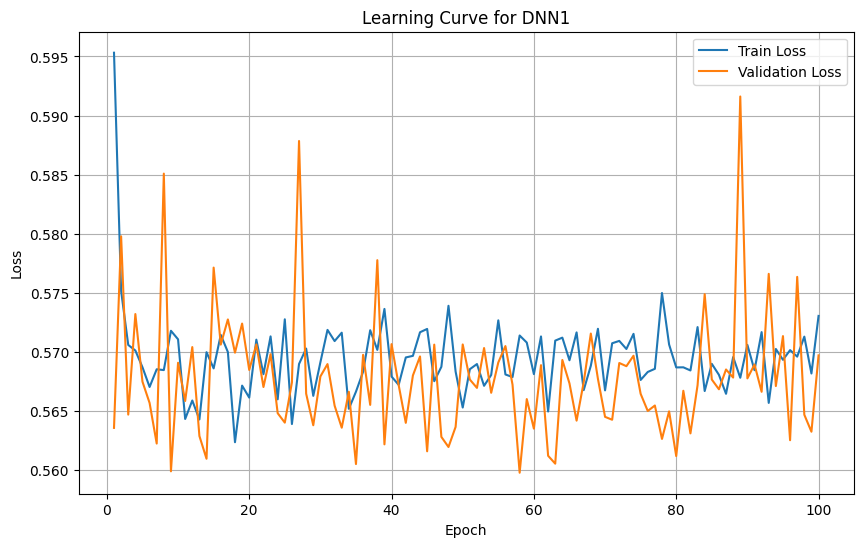

In [13]:
best_params=study.best_params
model = DNN_5(input_dim=X_train_tensor.shape[1],dropout_rate=best_params["dropout_rate"]).to(device)

# 最適化と訓練を実行
optimizer = optim.Adam(model.parameters(), lr=best_params["learning_rate"],weight_decay=best_params["weight_decay"])
criterion = nn.BCELoss()

num_epochs=100
train_losses = []
val_losses = []

model.train()
for epoch in range(num_epochs):
    epoch_train_loss = 0
    epoch_val_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch.squeeze())
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}')

    if val_loader is not None:
        model.eval()  
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val).squeeze()
                val_loss = criterion(val_outputs, y_val.squeeze())
                epoch_val_loss += val_loss.item()

        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        model.train()  

    if val_loader is not None:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    else:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
if val_losses:
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve for DNN1')
plt.legend()
plt.grid()
plt.show()

Accuracy: 58.54%
Precision: 0.4807
Recall: 0.9174
F1 Score: 0.6308
Matthews Correlation Coefficient: 0.3251
Specificity: 0.3766


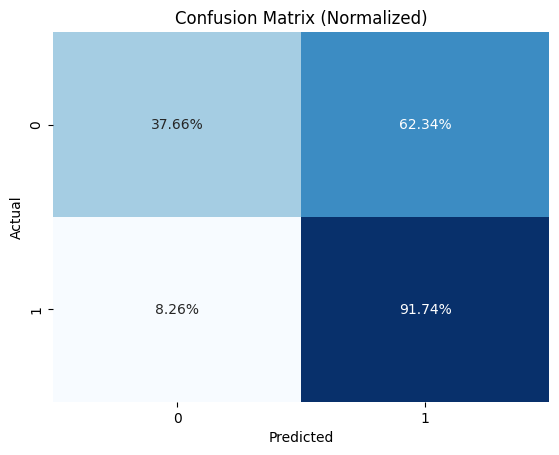

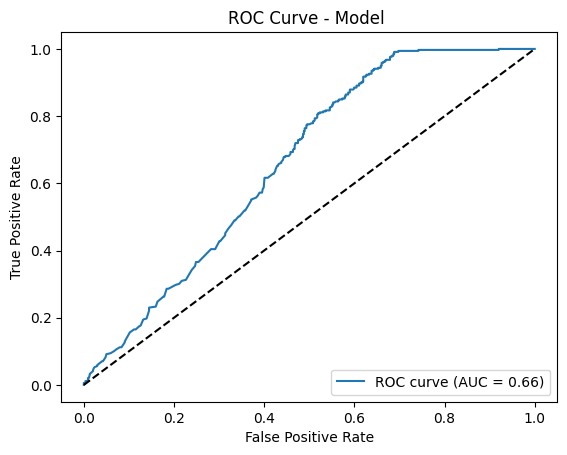

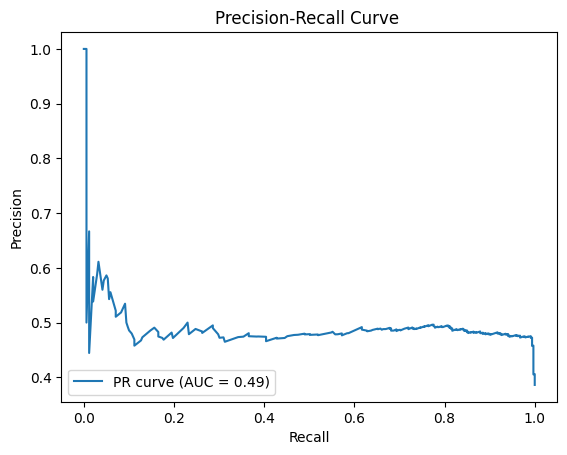

In [14]:
model.eval()
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    y_test_tensor = y_test_tensor.to(device)

    # 予測と確率
    test_outputs = model(X_test_tensor).squeeze()
    predictions = (test_outputs >0.49).float()
    y_true = y_test_tensor.cpu().numpy()
    y_pred = predictions.cpu().numpy()
    y_prob = test_outputs.cpu().numpy()

# 評価指標
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    specificity = recall_score(y_true, y_pred, pos_label=0)  
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Matthews Correlation Coefficient: {mcc:.4f}')
    print(f'Specificity: {specificity:.4f}')

    # 混同行列（割合表示）
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    sns.heatmap(cm, annot=True, fmt=".2%", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix (Normalized)")
    plt.show()

    # ROC曲線とAUC
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Model ')
    plt.legend(loc="lower right")
    plt.show()

    # Precision-Recall曲線
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall_curve, precision_curve)
    plt.plot(recall_curve, precision_curve, label=f'PR curve (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve ')
    plt.legend(loc="lower left")
    plt.show()    

In [15]:
# モデルと構造を保存
torch.save(model.state_dict(), '../../saved_model/DNN_5.pth')
